##neural network

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report,ConfusionMatrixDisplay

import tensorflow as tf
%matplotlib inline

2024-06-17 05:44:03.680688: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-17 05:44:03.683530: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-17 05:44:03.734551: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-17 05:44:03.736603: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-17 05:44:04.698727: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
# inpDir = os.path.join('..','..','input')
# outDir = 
# subDir = 

# Set parameters for decoration of plots
params = {'legend.fontsize' : 'large',
            'figure.figsize'  : (9,9),
            'axes.labelsize'  : 'x-large',
            'axes.titlesize'  :'x-large',
            'xtick.labelsize' :'large',
            'ytick.labelsize' :'large',
            }

CMAP = plt.cm.brg
plt.rcParams.update(params) # update rcParams
plt.set_cmap(CMAP)

plt.style.use('bmh')

EPOCHS = 100 #number of epochs
BATCH_SIZE = 32
ALPHA = 0.001 #learning rate

ES_PATIENCE = 10 #if performance doee not improve stop
LR_PATIENCE = 5 #if eperformance is not improving reduce alpha
LR_FACTOR = 0.1 # rate of reduction of alpha

<Figure size 900x900 with 0 Axes>

In [3]:
#function to plot history
def fn_plot_hist(hist_df):
    
    fig, axes = plt.subplots(1,2,figsize = (15,6))
    
    props = dict(boxstyle='round', facecolor='cyan', alpha =0.4, edgecolor = 'b')
    
    ax = axes[0]
    
    hist_df.plot(y = [hist_df.columns[0],hist_df.columns[2]], ax =ax, colormap=CMAP)
    
    lossmin = hist_df[hist_df.columns[0]].min()
    
    testmin = hist_df[hist_df.columns[2]].min()
    
    fmtStr = "Min {}: \n Traiining : {:7.4f}\n Testing  :  {:7.4f}"
    
    txtstr = fmtStr.format(hist_df.columns[0], lossmin, testmin) #text to plot
    
    ax.text(0.4, 0.95, txtstr, transform=ax.transAxes, fontsize= 14, verticalalignment='top', bbox=props)
    
    ax.set_xlabel("Epochs")
    
    ax.set_ylabel(hist_df.columns[0].capitalize())
    ax = axes[1]
    hist_df.plot( y = [hist_df.columns[1], hist_df.columns[3]], ax=ax, colormap=CMAP)
    
    #little beautification
    accmin = hist_df[hist_df.columns[1]].max()    
    
    testmin = hist_df[hist_df.columns[3]].max()
    
    fmtStr = "Max {}: \n Training : {:7.4f}\n Testing  : {:7.4f}"
    txtstr = fmtStr.format(hist_df.columns[1], accmin, testmin) #text to plot
    
    ax.text(0.4, 0.5, txtstr, transform=ax.transAxes, fontsize= 14, verticalalignment='top', bbox=props)
    
    ax.set_xlabel("Epochs")
    
    ax.set_ylabel(hist_df.columns[1].capitalize())
    
    plt.tight_layout()

Generate Datasets

In [4]:
train_filename = os.path.join('/home/hpcap/Desktop/modules/Ai/ML lab/DAY7/fashion-mnist_train.csv')
test_filename = os.path.join('/home/hpcap/Desktop/modules/Ai/ML lab/DAY7/fashion-mnist_test.csv')

train_df = pd.read_csv(train_filename, header = 0)
test_df = pd.read_csv(test_filename, header = 0)

<table>
  <tr>
    <th>Label</th>
    <th>Class</th>
  </tr>
  <tr>
    <td>0</td>
    <td>T-shirt/top</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Trouser</td>
  </tr>
    <tr>
    <td>2</td>
    <td>Pullover</td>
  </tr>
    <tr>
    <td>3</td>
    <td>Dress</td>
  </tr>
    <tr>
    <td>4</td>
    <td>Coat</td>
  </tr>
    <tr>
    <td>5</td>
    <td>Sandal</td>
  </tr>
    <tr>
    <td>6</td>
    <td>Shirt</td>
  </tr>
    <tr>
    <td>7</td>
    <td>Sneaker</td>
  </tr>
    <tr>
    <td>8</td>
    <td>Bag</td>
  </tr>
    <tr>
    <td>9</td>
    <td>Ankle boot</td>
  </tr>
</table>

Each image is mapped to a single label. Since the *class names* are not included with the dataset, store them here to use later when plotting the images:

>class_names = {0: 'T-shirt/top',1:'Trouser',2:'Pullover',3:'Dress',4:'Coat',
               5:'Sandal', 6: 'Shirt',7: 'Sneaker', 8:'Bag', 9: 'Ankle boot'}
               

In [5]:
class_names = {0: 'T-shirt/top',1:'Trouser',2:'Pullover',3:'Dress',4:'Coat',
            5:'Sandal', 6: 'Shirt',7: 'Sneaker', 8:'Bag', 9: 'Ankle boot'}

In [6]:
###-----------------------------------
### Function to plot Loss Curve
###-----------------------------------

def fn_plot_tf_hist(hist_df : pd.DataFrame):
    '''
    Args:
      hist_df : pandas Dataframe with four columns
                For 'x' values, we will use index
    '''
    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)
    facecolor = 'cyan'
    fontsize=12
    
    # Get columns by index to eliminate any column naming error
    y1 = hist_df.columns[0]
    y2 = hist_df.columns[1]
    y3 = hist_df.columns[2]
    y4 = hist_df.columns[3]

    # Where was min loss
    best = hist_df[hist_df[y3] == hist_df[y3].min()]
    
    ax = axes[0]

    hist_df.plot(y = [y1,y3], ax = ax, colormap=CMAP)


    # little beautification
    txtFmt = "Loss: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y3]) #text to plot
    
    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y3].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y3].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy()-1, best[y3].to_numpy()[0]), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow

    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y1.capitalize())
    ax.set_title('Errors')
    ax.grid();
    ax.legend(loc = 'upper left') # model legend to upper left

    ax = axes[1]

    hist_df.plot( y = [y2, y4], ax = ax, colormap=CMAP)
    
    # little beautification
    txtFmt = "Accuracy: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y2],
                           hist_df.iloc[-1][y4]) #text to plot

    # place a text box in upper middle in axes
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy()-1, best[y4].to_numpy()[0]), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow
    
    
    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y2.capitalize())
    ax.grid()
    ax.legend(loc = 'lower left')
    
    plt.tight_layout()

In [7]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


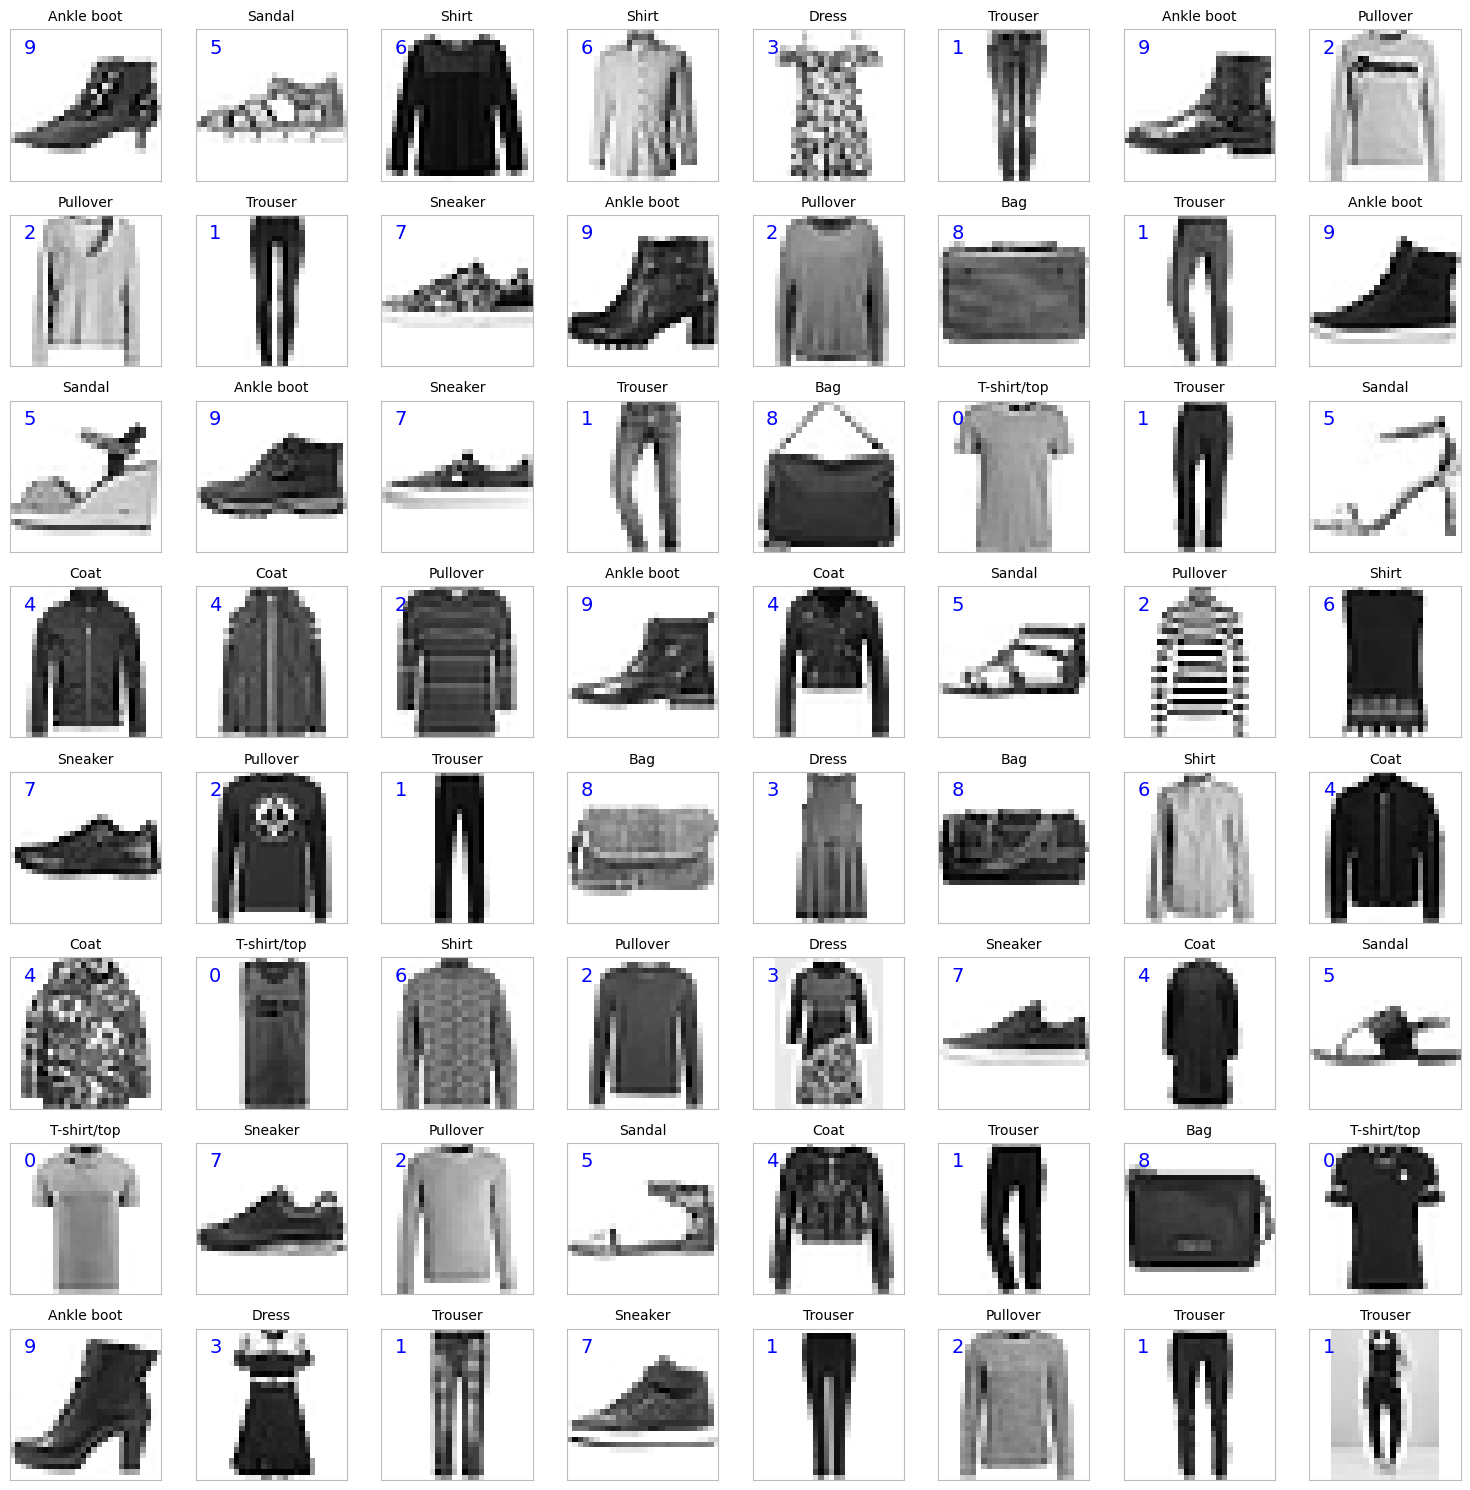

In [8]:
# Sample data plot

plot_df = train_df.sample(n = 64) # Take 100 sample from the training set

fig = plt.figure(figsize=(15, 15))  # figure size in inches

fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05) # adjust subplots

i = 0

for _ , row in plot_df.iterrows(): # iterate through all rows of the dataframe
    
    i = i + 1
    
    image = row.values[1:].reshape(28,28) # reshape row to a 28x28 matrix
    
    ax = fig.add_subplot(8, 8, (i), xticks=[], yticks=[]) # add a subplot to the figure
    
    ax.imshow(image, cmap=plt.cm.binary, interpolation='nearest') # show image on the axis
    
    ax.text(2, 4, str(row.iloc[0]), color='b', fontsize=14)   # add number (class) of the image
    
    ax.set_title(class_names[row.iloc[0]], fontsize=10)   # add name of the image

plt.tight_layout() 
plt.show()

In [9]:
X_train = train_df.drop('label', axis = 1).to_numpy()
y_train = train_df['label'].to_numpy()

X_test = test_df.drop('label', axis = 1).to_numpy()
y_test = test_df['label'].to_numpy()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((60000, 784), (10000, 784), (60000,), (10000,))

In [10]:
X_train.max()

255

DAY 9 Continue

In [11]:
X_train.min()

0

In [12]:
X_train = X_train / 255.0

X_test = X_test / 255.0

Prepare Model
Build tf.keras.Sequential model by tf.keras.layers.Dense

In [13]:
model = tf.keras.Sequential([tf.keras.layers.Dense(784//4, activation = 'relu'),tf.keras.layers.Dense(784//16, activation = 'relu'), tf.keras.layers.Dense(10)#Ten classes 
])
#model.ouput_shape

2024-06-17 05:44:14.856084: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [14]:
X_train[:1].shape

(1, 784)

In [15]:
predictions = model(X_train[:1])
predictions.numpy()

array([[-1.5726237 , -0.56091124, -0.7883943 ,  0.330802  ,  1.1277337 ,
         0.00898319, -0.04111294,  0.3757292 ,  1.3490334 , -0.0178212 ]],
      dtype=float32)

In [16]:
tf.nn.softmax(predictions).numpy().sum()

1.0000001

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (1, 196)                  153860    
                                                                 
 dense_1 (Dense)             (1, 49)                   9653      
                                                                 
 dense_2 (Dense)             (1, 10)                   500       
                                                                 
Total params: 164013 (640.68 KB)
Trainable params: 164013 (640.68 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [18]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits= True)

In [19]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=ALPHA),
                loss=loss_fn,
                metrics=['accuracy'])
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose='auto',
    validation_data=[X_test, y_test])

Epoch 1/100
1875/1875 [==============================] - 11s 6ms/step - loss: 0.4991 - accuracy: 0.8236 - val_loss: 0.3844 - val_accuracy: 0.8580
Epoch 2/100
1875/1875 [==============================] - 10s 6ms/step - loss: 0.3733 - accuracy: 0.8623 - val_loss: 0.3457 - val_accuracy: 0.8747
Epoch 3/100
1875/1875 [==============================] - 10s 6ms/step - loss: 0.3355 - accuracy: 0.8769 - val_loss: 0.3327 - val_accuracy: 0.8755
Epoch 4/100
1875/1875 [==============================] - 11s 6ms/step - loss: 0.3134 - accuracy: 0.8842 - val_loss: 0.3440 - val_accuracy: 0.8742
Epoch 5/100
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2956 - accuracy: 0.8913 - val_loss: 0.3232 - val_accuracy: 0.8806
Epoch 6/100
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2815 - accuracy: 0.8955 - val_loss: 0.3030 - val_accuracy: 0.8905
Epoch 7/100
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2691 - accuracy: 0.8994 - val_loss: 0.3265 -

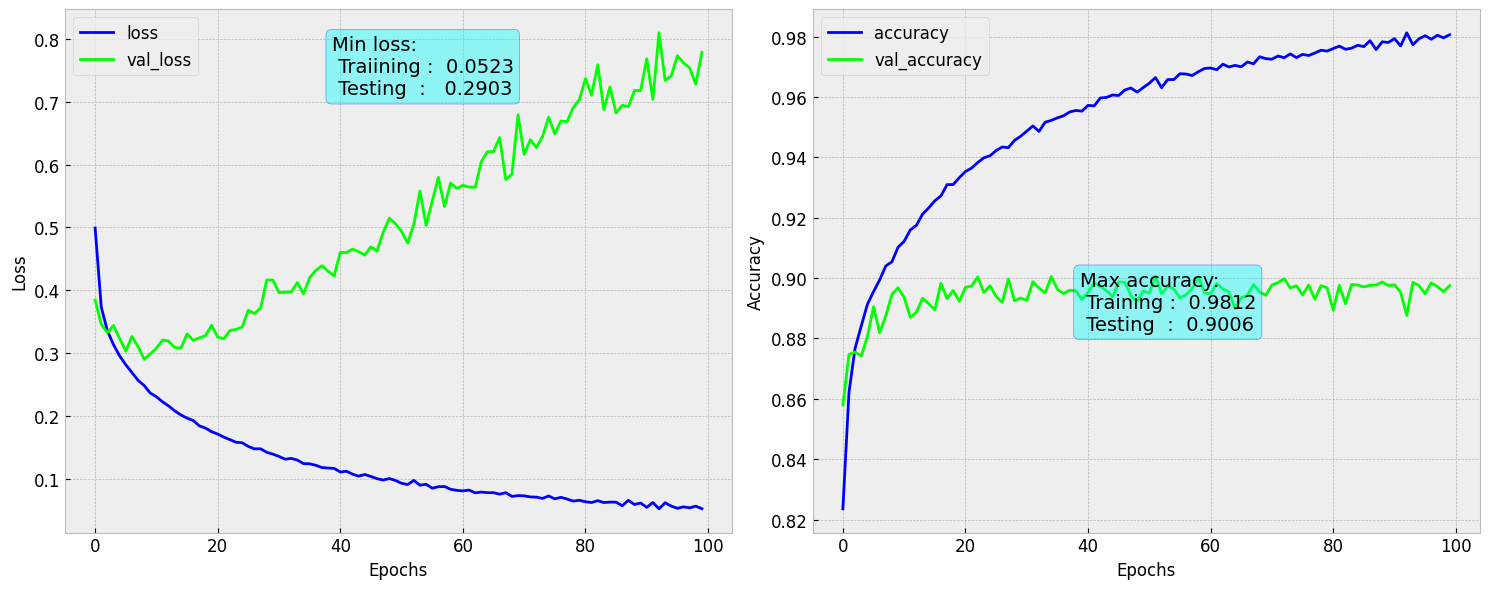

In [20]:
hist_df = pd.DataFrame(history.history)
fn_plot_hist(hist_df)

In [21]:
y_pred = model.predict(X_train)
y_pred = y_pred.argmax(axis=1)
print("Accuracy score on Train Data : ", accuracy_score(y_train, y_pred))

1875/1875 [==============================] - 5s 2ms/step
Accuracy score on Train Data :  0.9846166666666667


In [22]:
print(classification_report(y_train,y_pred))

              precision    recall  f1-score   support

           0       0.99      0.96      0.98      6000
           1       1.00      0.99      1.00      6000
           2       0.96      0.98      0.97      6000
           3       0.97      1.00      0.98      6000
           4       0.97      0.96      0.97      6000
           5       1.00      1.00      1.00      6000
           6       0.97      0.96      0.96      6000
           7       1.00      1.00      1.00      6000
           8       1.00      1.00      1.00      6000
           9       1.00      1.00      1.00      6000

    accuracy                           0.98     60000
   macro avg       0.98      0.98      0.98     60000
weighted avg       0.98      0.98      0.98     60000



In [24]:
cm = confusion_matrix(y_train,y_pred)

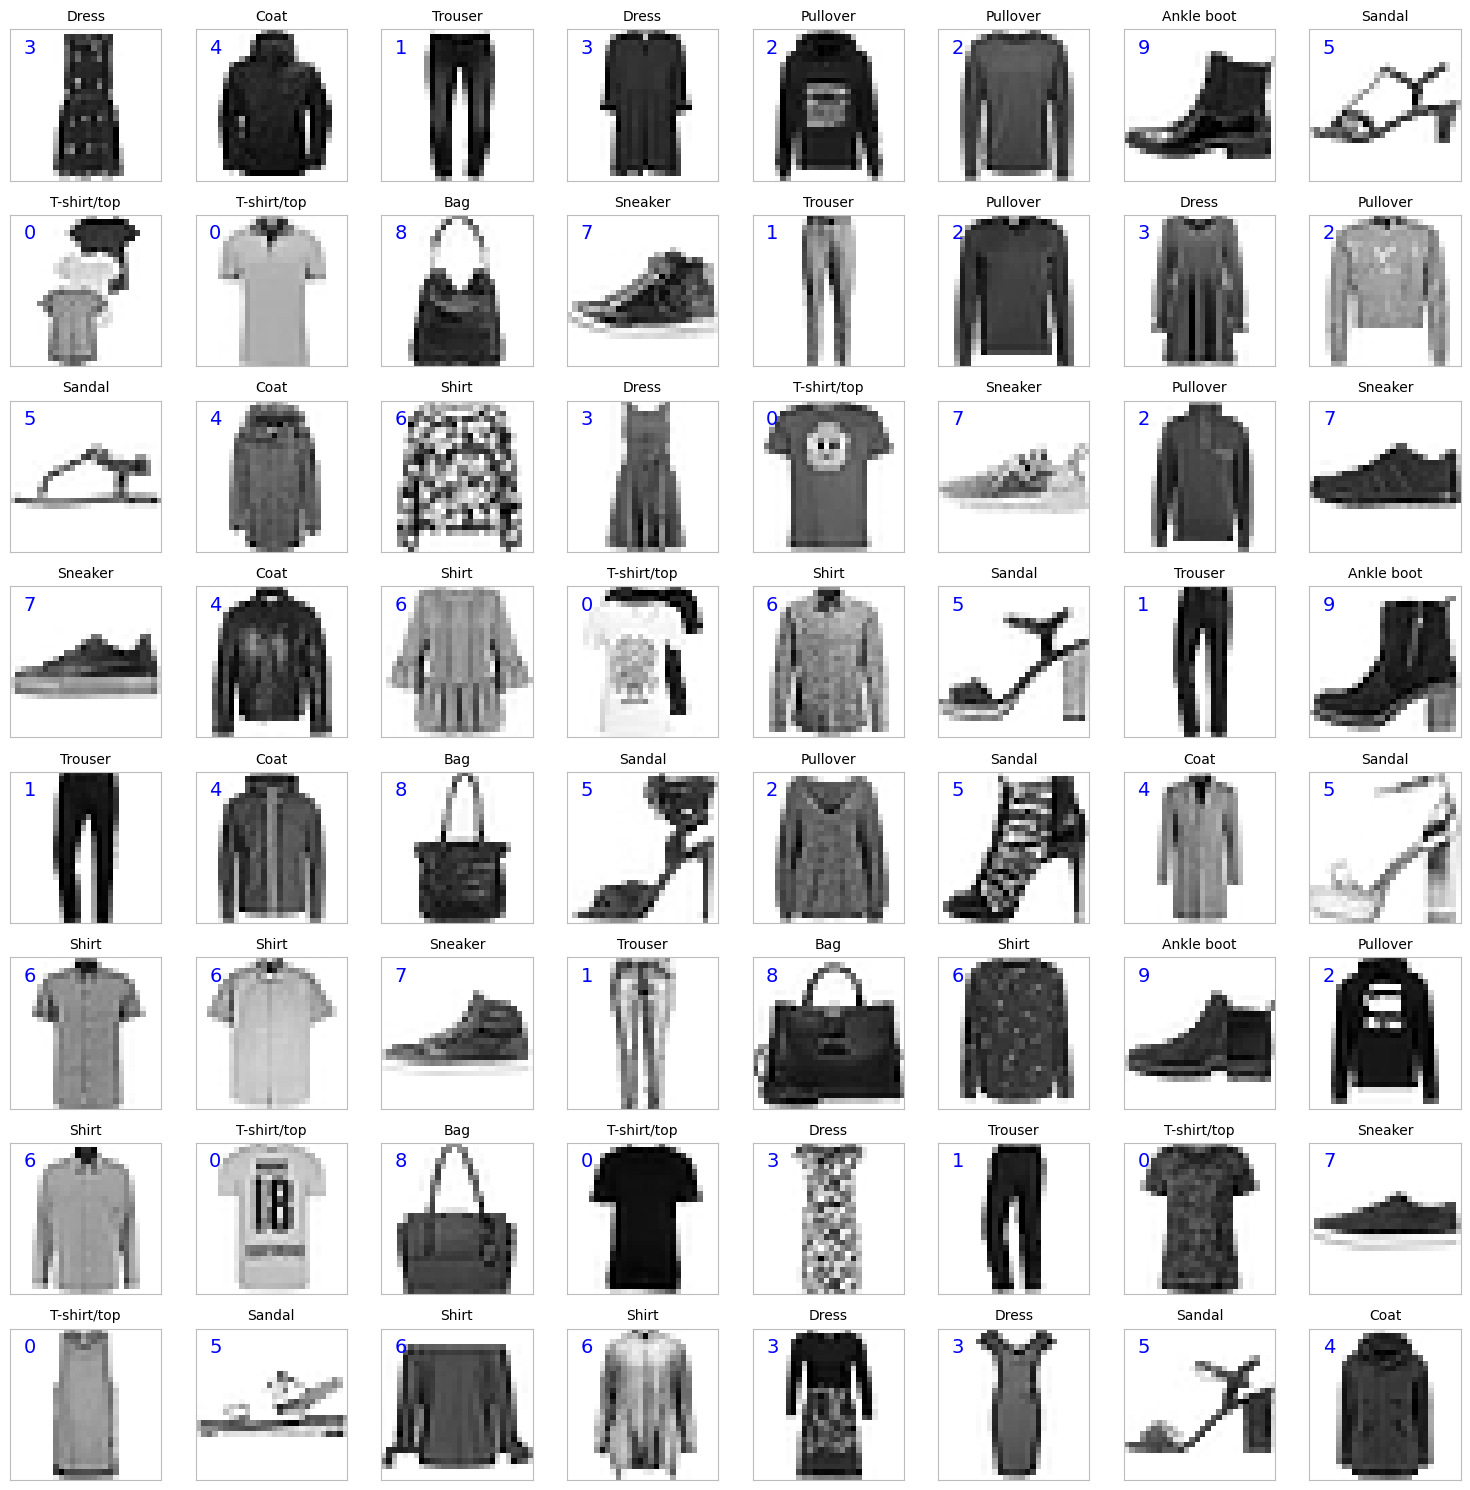

In [28]:
# Sample data plot

plot_df = train_df.sample(n = 64) # Take 100 sample from the training set

fig = plt.figure(figsize=(15, 15))  # figure size in inches

fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05) # adjust subplots

i = 0

for _ , row in plot_df.iterrows(): # iterate through all rows of the dataframe
    
    i = i + 1
    
    image = row.values[1:].reshape(28,28) # reshape row to a 28x28 matrix
    
    ax = fig.add_subplot(8, 8, (i), xticks=[], yticks=[]) # add a subplot to the figure
    
    ax.imshow(image, cmap=plt.cm.binary, interpolation='nearest') # show image on the axis
    
    ax.text(2, 4, str(row.iloc[0]), color='b', fontsize=14)   # add number (class) of the image
    
    ax.set_title(class_names[row.iloc[0]], fontsize=10)   # add name of the image

plt.tight_layout() 
plt.show()